# Retirement Forecast

In [14]:
import logging
from logging.handlers import RotatingFileHandler
import polars as pl
import numpy as np
from great_tables import GT
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates
from datetime import datetime
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
from IPython.display import Markdown, display


import sys
from pathlib import Path

# Get the directory containing this notebook file
notebook_dir = Path(__file__).parent if "__file__" in globals() else Path.cwd() / "notebooks"
sys.path.append(str(notebook_dir))

from plugins.constants import num_trading_days, LifePhases
from plugins.modeler import run_multi_asset_simulation


%config InlineBackend.figure_format = "retina"
sns.set_theme()

## Simulation Configuration

In [15]:
# Description of the simulation
description = "A sample simulation of a 30 year old making modest contributions every year, working part time after 65, and retiring at 70."

# Source of the parameters (for documentation purposes)
parameter_source = "this notebook"

# Number of Monte Carlo simulations to run
num_simulations = 10
simulation_end_age = 90
inflation_rate = 0.032

# Acceptable values: "linear" or "log"
y_axis_scale = "linear"

# Logging configuration
logging_enabled = False
logging_level = "DEBUG"
logging_file = "simulation.log"

life_phases = [
    {
        "name": "Early Career",
        "age": 30,
        "annual_income": 90_000,
        "annual_expenses": 70_000,
        "annual_investment": 20_000,
        "investment_allocation": {"savings": 1.0},
        "actions": [
            {
                "type": "grant_asset",
                "name": "savings",
                "config": {
                    "type": "basic_asset",
                    "params": {
                        "initial_investment": 0,
                        "expected_return": 0.05,
                        "volatility": 0.15,
                    },
                },
            }
        ],
    },
    {
        "name": "Part Time",
        "age": 65,
        "annual_income": 20_000,
        "annual_investment": 0,
    },
    {
        "name": "Retire",
        "age": 70,
        "annual_income": 0,
        "annual_investment": 0,
    },
]

# # Example: Load configuration from a YAML file
import yaml

with open("../sample_papermill_settings.yaml", "r") as f:
     config = yaml.safe_load(f)
description = config["description"]
num_simulations = config["num_simulations"]
life_phases = config["life_phases"]

In [16]:
if logging_enabled:
    root_logger = logging.getLogger()
    root_logger.setLevel(logging.getLevelName(logging_level))

    # Add rotating file handler
    handler = RotatingFileHandler(logging_file, maxBytes=2_000_000, backupCount=3)
    formatter = logging.Formatter("%(asctime)s %(name)s %(levelname)s %(message)s")
    handler.setFormatter(formatter)
    root_logger.addHandler(handler)

validated_life_phases = LifePhases(life_phases=life_phases)

In [17]:
simulation_start_age: int = int(life_phases[0]["age"])
num_years = simulation_end_age - simulation_start_age
pi = 75

display(Markdown(description))
display(Markdown(f"Parameters sourced from: {parameter_source}"))

This configuration is a sample for a retirement planning scenario.

We imagine the 'perfect' retirement plan: starting saving at 20 years old, and saving 15% of their income.


Parameters sourced from: this notebook

## Summary of Life Phases

In [18]:
def summarize_life_phases(phases: list[dict]) -> GT:
    """
    Build a pretty table of life phases including actions.
    Columns: Phase, Age, Annual Income, Annual Expenses, Action, Type, Cost

    Changes:
    - Show an em-dash for Income/Expenses when the phase does not explicitly update them.
    - If a phase has multiple actions, only the first action row shows Phase/Age/Income/Expenses.
      Subsequent action rows for the same phase leave those columns blank.
    - If a phase has no actions, shows a single row with em-dash entries and zero cost.
    """
    rows: list[dict] = []
    for ph in phases:
        actions = ph.get("actions") or [None]
        first_row_for_phase = True

        # Determine whether this phase explicitly sets income/expenses
        has_income = "annual_income" in ph and ph.get("annual_income") is not None
        has_expenses = "annual_expenses" in ph and ph.get("annual_expenses") is not None

        income_value = float(ph["annual_income"]) if has_income else None
        expenses_value = float(ph["annual_expenses"]) if has_expenses else None

        for act in actions:
            if act is None:
                act_name = "—"
                act_type = "—"
                cost = 0.0
            else:
                act_name = act.get("name", "—")
                act_type = act.get("type", "—")

                # Extract params consistently whether nested under "config" or directly on the action
                params = {}
                if "params" in act and isinstance(act.get("params"), dict):
                    params = act.get("params") or {}
                elif "config" in act and isinstance(act.get("config"), dict):
                    cfg = act.get("config") or {}
                    params = cfg.get("params") or {}

                # Heuristic for cost:
                # - Prefer explicit initial_investment (e.g., for grant_asset)
                # - Otherwise use 'amount' if provided (e.g., buy/sell/modify)
                # - Default to 0.0 if not specified
                cost = params.get("initial_investment")
                if cost is None:
                    cost = params.get("amount")
                if cost is None:
                    cost = 0.0

            # Show phase details only on the first action row of the phase
            phase_cell = ph.get("name", "") if first_row_for_phase else None
            age_cell = int(ph.get("age", 0) or 0) if first_row_for_phase else None
            income_cell = income_value if first_row_for_phase else None
            expenses_cell = expenses_value if first_row_for_phase else None

            rows.append(
                {
                    "Phase": phase_cell,
                    "Age": age_cell,
                    "Income": income_cell,
                    "Expenses": expenses_cell,
                    "Action Name": act_name,
                    "Action Type": act_type,
                    "Cost": float(cost),
                }
            )

            first_row_for_phase = False

    df = pl.DataFrame(rows)

    return (
        GT(df)
        .tab_header(title="Summary of Life Phases")
        .cols_label(
            {
                "Phase": "Phase",
                "Age": "Age",
                "Income": "Annual Income",
                "Expenses": "Annual Expenses",
                "Action Name": "Action",
                "Action Type": "Type",
                "Cost": "Cost",
            }
        )
        .fmt_currency(["Income", "Expenses", "Cost"], decimals=0)
        .sub_missing(missing_text="—")
    )


summarize_life_phases(life_phases)

GT(_tbl_data=shape: (6, 7)
┌────────────────────────┬──────┬─────────┬──────────┬─────────────┬──────────────┬────────┐
│ Phase                  ┆ Age  ┆ Income  ┆ Expenses ┆ Action Name ┆ Action Type  ┆ Cost   │
│ ---                    ┆ ---  ┆ ---     ┆ ---      ┆ ---         ┆ ---          ┆ ---    │
│ str                    ┆ i64  ┆ f64     ┆ f64      ┆ str         ┆ str          ┆ f64    │
╞════════════════════════╪══════╪═════════╪══════════╪═════════════╪══════════════╪════════╡
│ Early Career           ┆ 20   ┆ 40000.0 ┆ 35000.0  ┆ savings     ┆ grant_asset  ┆ 1000.0 │
│ null                   ┆ null ┆ null    ┆ null     ┆ retirement  ┆ grant_asset  ┆ 1000.0 │
│ Better Job             ┆ 30   ┆ 80000.0 ┆ 65000.0  ┆ —           ┆ —            ┆ 0.0    │
│ Latter Career          ┆ 50   ┆ 95000.0 ┆ 70000.0  ┆ retirement  ┆ modify_asset ┆ 0.0    │
│ Retirement             ┆ 65   ┆ 0.0     ┆ 50000.0  ┆ —           ┆ —            ┆ 0.0    │
│ Retirement with Social ┆ 70   ┆ 20000.0 ┆ null     ┆ —           ┆ —            ┆ 0.0    │
│ Securit…               ┆      ┆         ┆          ┆             ┆              ┆        │
└────────────────────────┴──────┴─────────┴──────────┴─────────────┴──────────────┴────────┘, _body=<great_tables._gt_data.Body object at 0x121917a50>, _boxhead=Boxhead([ColInfo(var='Phase', type=<ColInfoTypeEnum.default: 1>, column_label='Phase', column_align='left', column_width=None), ColInfo(var='Age', type=<ColInfoTypeEnum.default: 1>, column_label='Age', column_align='right', column_width=None), ColInfo(var='Income', type=<ColInfoTypeEnum.default: 1>, column_label='Annual Income', column_align='right', column_width=None), ColInfo(var='Expenses', type=<ColInfoTypeEnum.default: 1>, column_label='Annual Expenses', column_align='right', column_width=None), ColInfo(var='Action Name', type=<ColInfoTypeEnum.default: 1>, column_label='Action', column_align='left', column_width=None), ColInfo(var='Action Type', type=<ColInfoTypeEnum.default: 1>, column_label='Type', column_align='left', column_width=None), ColInfo(var='Cost', type=<ColInfoTypeEnum.default: 1>, column_label='Cost', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x1218e4b10>, _spanners=Spanners([]), _heading=Heading(title='Summary of Life Phases', subtitle=None, preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x1218c3f50>, _formats=[<great_tables._gt_data.FormatInfo object at 0x1218b9a90>], _substitutions=[<great_tables._gt_data.FormatInfo object at 0x11d8e0e90>], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), 

In [19]:
# These functions fetch historical data and calculate the accurate risk/return profile for the stock portfolio.


def generate_trading_days(start_year: int, num_years: int) -> list:
    """Generate actual trading days for the simulation period, excluding weekends and major holidays."""
    start_date = datetime(start_year, 1, 1)
    end_date = datetime(start_year + num_years, 12, 31)

    calendar = USFederalHolidayCalendar()
    holidays = calendar.holidays(start=start_date, end=end_date)

    business_days = pd.bdate_range(start=start_date, end=end_date, freq="B")
    trading_days = business_days.drop(business_days.intersection(holidays))

    return [day.to_pydatetime() for day in trading_days]


simulated_totals_df, simulated_assets_df, final_values, investment_fn, draw_fn = run_multi_asset_simulation(
    validated_life_phases.life_phases,
    num_years,
    num_simulations,
    inflation_rate
)

# Determine the set of asset names present over the simulation from outputs only
asset_names = sorted(simulated_assets_df.keys())

In [20]:
def add_lifecycle_milestones(ax, show_legend=True):
    """
    Adds vertical lines for key lifecycle milestones to any plot.
    This function now dynamically reads from the life_phases config.

    Fix: compute milestone offsets relative to the first phase age,
    not cumulatively against the first phase every loop.
    """
    current_year = datetime.now().year
    milestone_lines = []

    if len(life_phases) <= 1:
        return

    palette = sns.color_palette("husl", len(life_phases) - 1)
    for i in range(1, len(life_phases)):  # start from the second phase
        offset_years = life_phases[i]["age"] - life_phases[0]["age"]
        line_date = datetime(current_year + offset_years, 1, 1)
        line = ax.axvline(
            line_date,
            color=palette[i - 1],
            linestyle="--",
            alpha=0.8,
            label=life_phases[i]["name"],
        )
        milestone_lines.append(line)

    if show_legend and milestone_lines:
        handles, labels = ax.get_legend_handles_labels()
        milestone_handles = milestone_lines
        milestone_labels = [line.get_label() for line in milestone_lines]

        if handles:
            ax.legend(handles + milestone_handles, labels + milestone_labels, loc="upper left")
        else:
            ax.legend(milestone_handles, milestone_labels, loc="upper left")

In [21]:

display(
    Markdown(f"""
## Summary of Outcomes

The table below shows the results of running {num_simulations} simulations of the portfolio over {num_years} years.

The `Percent > 0` column indicates the percentage of simulations where the final value was greater than zero, which is a measure of success for the portfolio.

Portfolio managers typically aim for a success rate of 75% or higher.
""")
)


## Summary of Outcomes

The table below shows the results of running 500 simulations of the portfolio over 70 years.

The `Percent > 0` column indicates the percentage of simulations where the final value was greater than zero, which is a measure of success for the portfolio.

Portfolio managers typically aim for a success rate of 75% or higher.


In [22]:


def calculate_asset_statistics(assets_df, total_final_values):
    """Calculate percentiles, volatility, and approximate initial values using only simulation outputs."""
    stats = {}

    # Compute approximate initial total from assets' first simulated values
    initial_total = 0.0

    # Add individual asset stats and accumulate initial values
    for name, df in assets_df.items():
        # Detect the value column dynamically
        value_cols = [c for c in df.columns if c.endswith("_value")]
        if not value_cols:
            continue
        value_col = value_cols[0]

        # Final values per simulation
        final_values = (
            df.sort(["simulation", "trading_day"])
            .with_columns(pl.col(value_col).last().over("simulation").alias("_final"))
            .unique(subset=["simulation"])
            .select("_final")
            .to_series()
            .to_numpy()
        )

        # First values per simulation (may be zero before asset is introduced)
        first_values = (
            df.sort(["simulation", "trading_day"])
            .with_columns(pl.col(value_col).first().over("simulation").alias("_first"))
            .unique(subset=["simulation"])
            .select("_first")
            .to_series()
            .to_numpy()
        )

        initial_avg = float(np.mean(first_values)) if len(first_values) else 0.0
        initial_total += initial_avg

        stats[name.title()] = {
            "p25": np.percentile(final_values, 25),
            "median": np.median(final_values),
            "p75": np.percentile(final_values, 75),
            "p95": np.percentile(final_values, 95),
            "volatility": np.std(final_values),
            "initial": initial_avg,
            "prob_success": np.mean(final_values > 0),
            "perc_success": (final_values > 0).sum() / num_simulations,
        }

    # Add total portfolio stats
    stats["Total"] = {
        "initial": initial_total,
        "median": np.median(total_final_values),
        "perc_success": (total_final_values > 0).sum() / num_simulations,
    }

    return stats


def asset_stats_to_polars_df(asset_stats):
    """Convert asset_stats dict to a Polars DataFrame with formatted columns using great_tables"""
    metrics = [
        ("Initial Investment", lambda s: s["initial"]),
        ("Median", lambda s: s["median"]),
        ("Percent > 0", lambda s: s["perc_success"]),
    ]

    assets = list(asset_stats.keys())

    # Build data dict as plain Python lists of scalars
    data = {"Metric": [m[0] for m in metrics]}
    for asset in assets:
        values = [fmt(asset_stats[asset]) for _, fmt in metrics]
        # Convert all numpy types to Python floats/ints
        values = [
            v.item()
            if isinstance(v, np.generic)
            else float(v)
            if isinstance(v, (int, float, np.floating))
            else v
            for v in values
        ]
        data[asset] = values

    # Create Polars DataFrame safely
    df = pl.DataFrame({k: list(v) for k, v in data.items()})

    # Format columns using great_tables
    return (
        GT(df)
        .fmt_currency(["Total"] + assets, decimals=0)
        .fmt_percent(["Total"] + assets, rows=[-1], decimals=0)
        .fmt_currency(["Total"] + assets, rows=[-2], decimals=0)
    )


# Calculate statistics for all assets
asset_stats = calculate_asset_statistics(simulated_assets_df, final_values)

asset_stats_to_polars_df(asset_stats)

Metric,Retirement,Savings,Total
Initial Investment,"$1,001","$1,000","$2,001"
Median,"$3,290,522",$0,"$3,290,522"
Percent > 0,63%,0%,63%


## Visualizations

### Total Portfolio Value Projection

This chart shows the aggregated value of all asset classes over time. The shaded area represents the 75% prediction interval, showing the range of most likely outcomes.

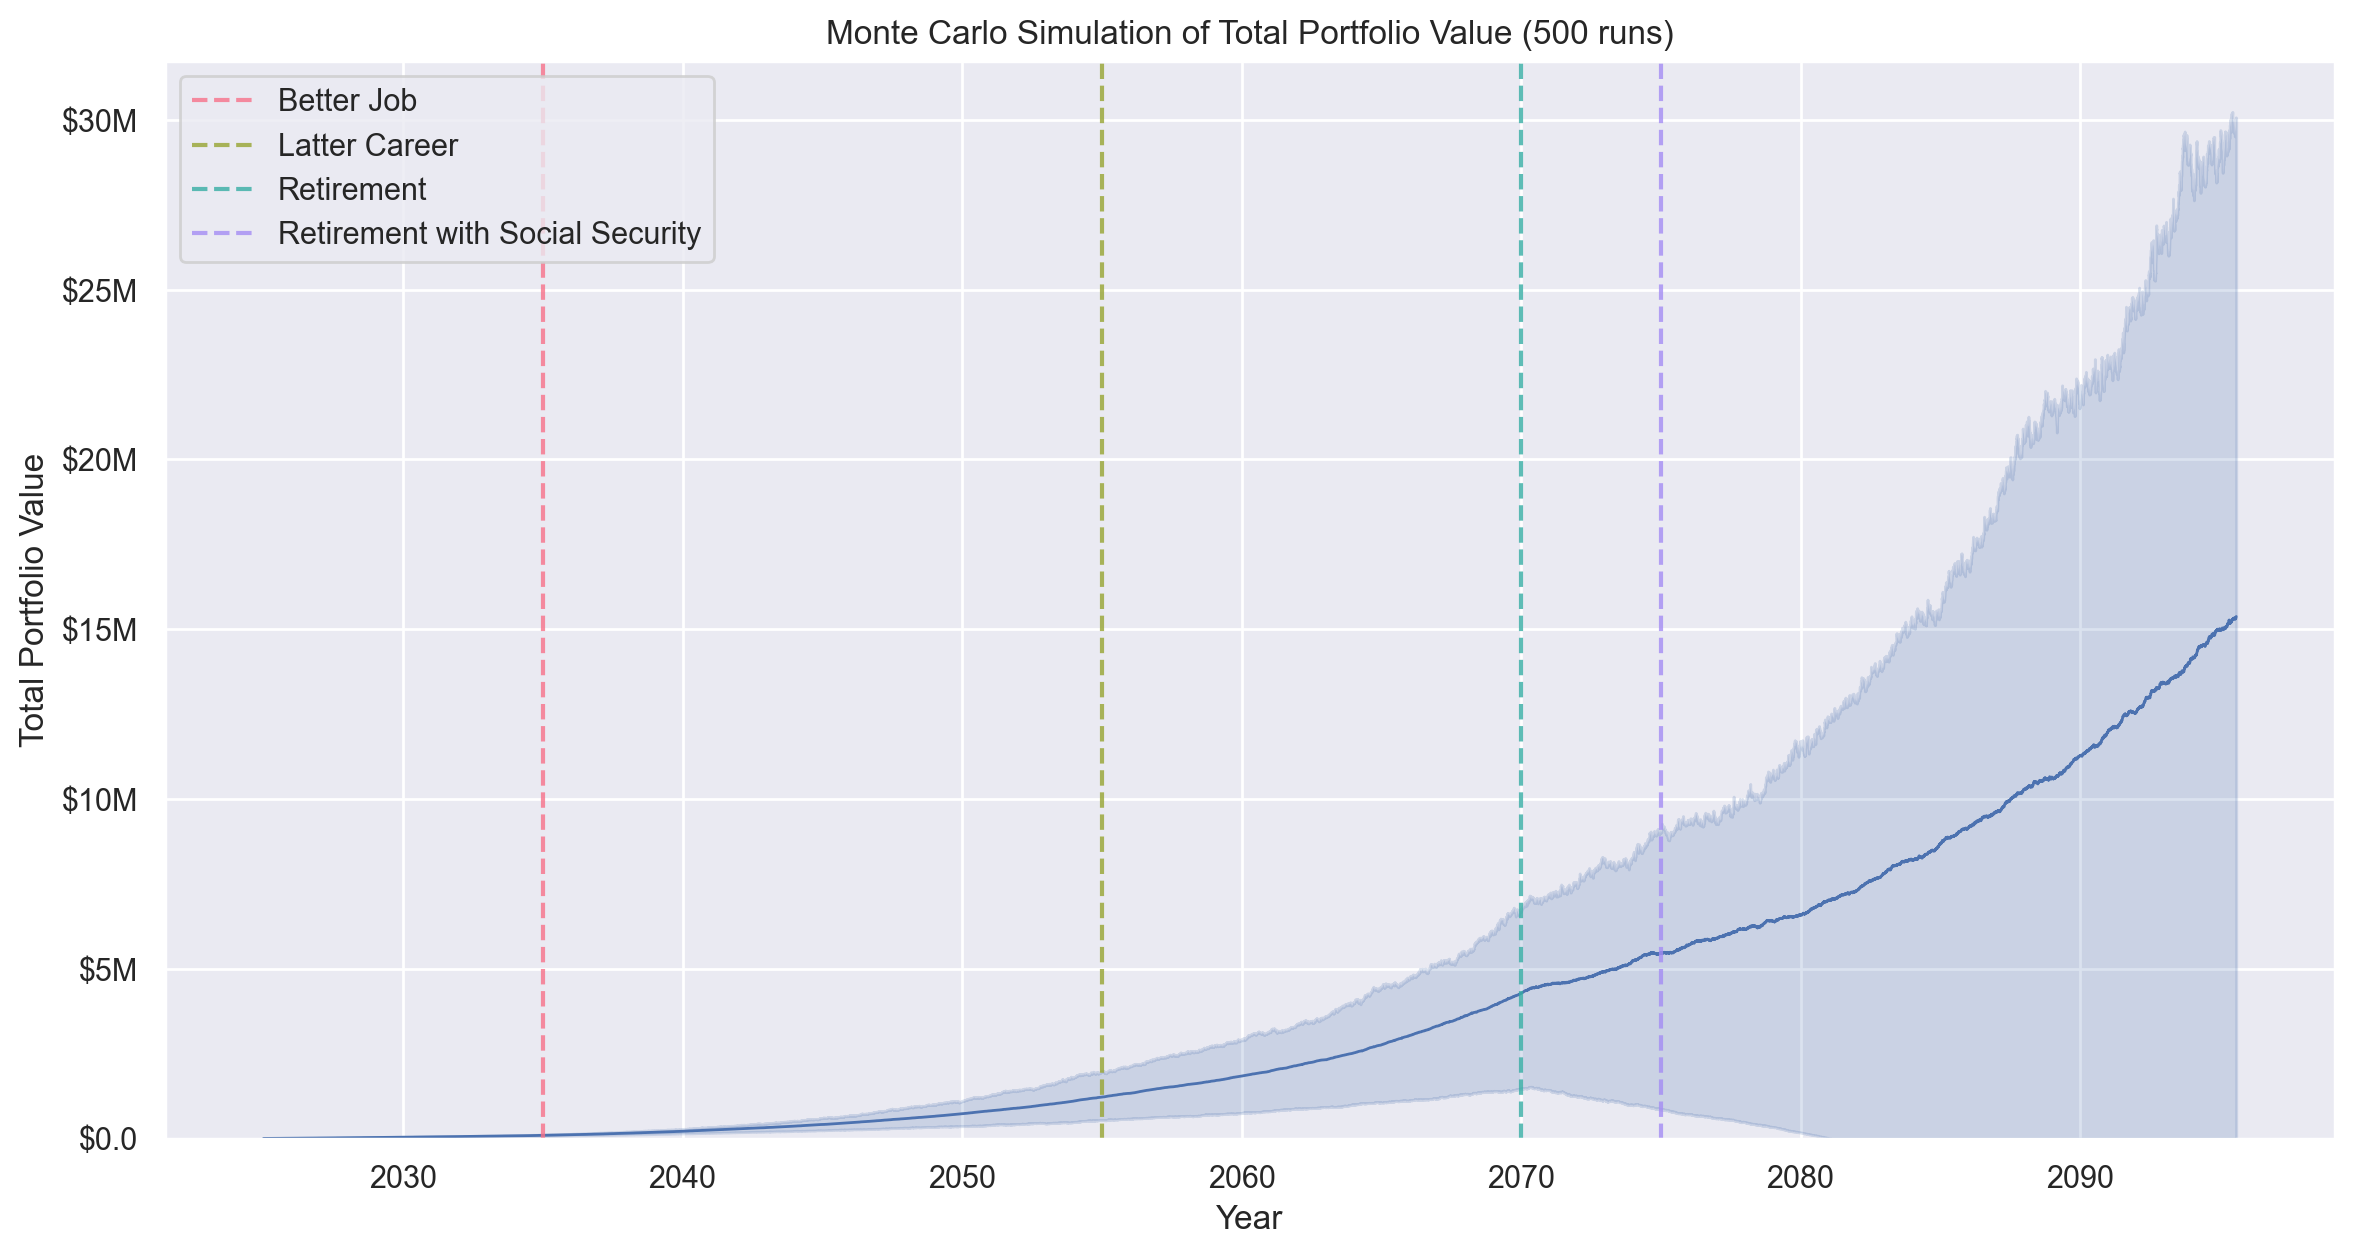

In [23]:
def money_formatter(x, pos):
    if x < 1_000:
        return f"${x}"
    elif x < 1_000_000:
        return f"${int(x / 1_000)}k"
    else:
        return f"${int(x / 1_000_000)}M"


fig, ax = plt.subplots(figsize=(14, 7))
sns.lineplot(
    ax=ax,
    data=simulated_totals_df,
    x="trading_date",
    y="portfolio_value",
    legend=False,
    linewidth=1,
    errorbar=("pi", pi),
)
add_lifecycle_milestones(ax)
if y_axis_scale == "log":
    ax.set_yscale("log")
    ax.set_ylim(bottom=1)
else:
    ax.set_yscale("linear")
    ax.set_ylim(bottom=0)

# Mark significant life events
ax.yaxis.set_major_formatter(FuncFormatter(money_formatter))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.xlabel("Year")
plt.ylabel("Total Portfolio Value")
plt.title(f"Monte Carlo Simulation of Total Portfolio Value ({num_simulations} runs)")
plt.legend(loc="upper left")
plt.show()

### Individual Asset Class Projections

These charts show the median projection for each individual asset class, allowing for a deeper analysis of how each component contributes to the total portfolio.

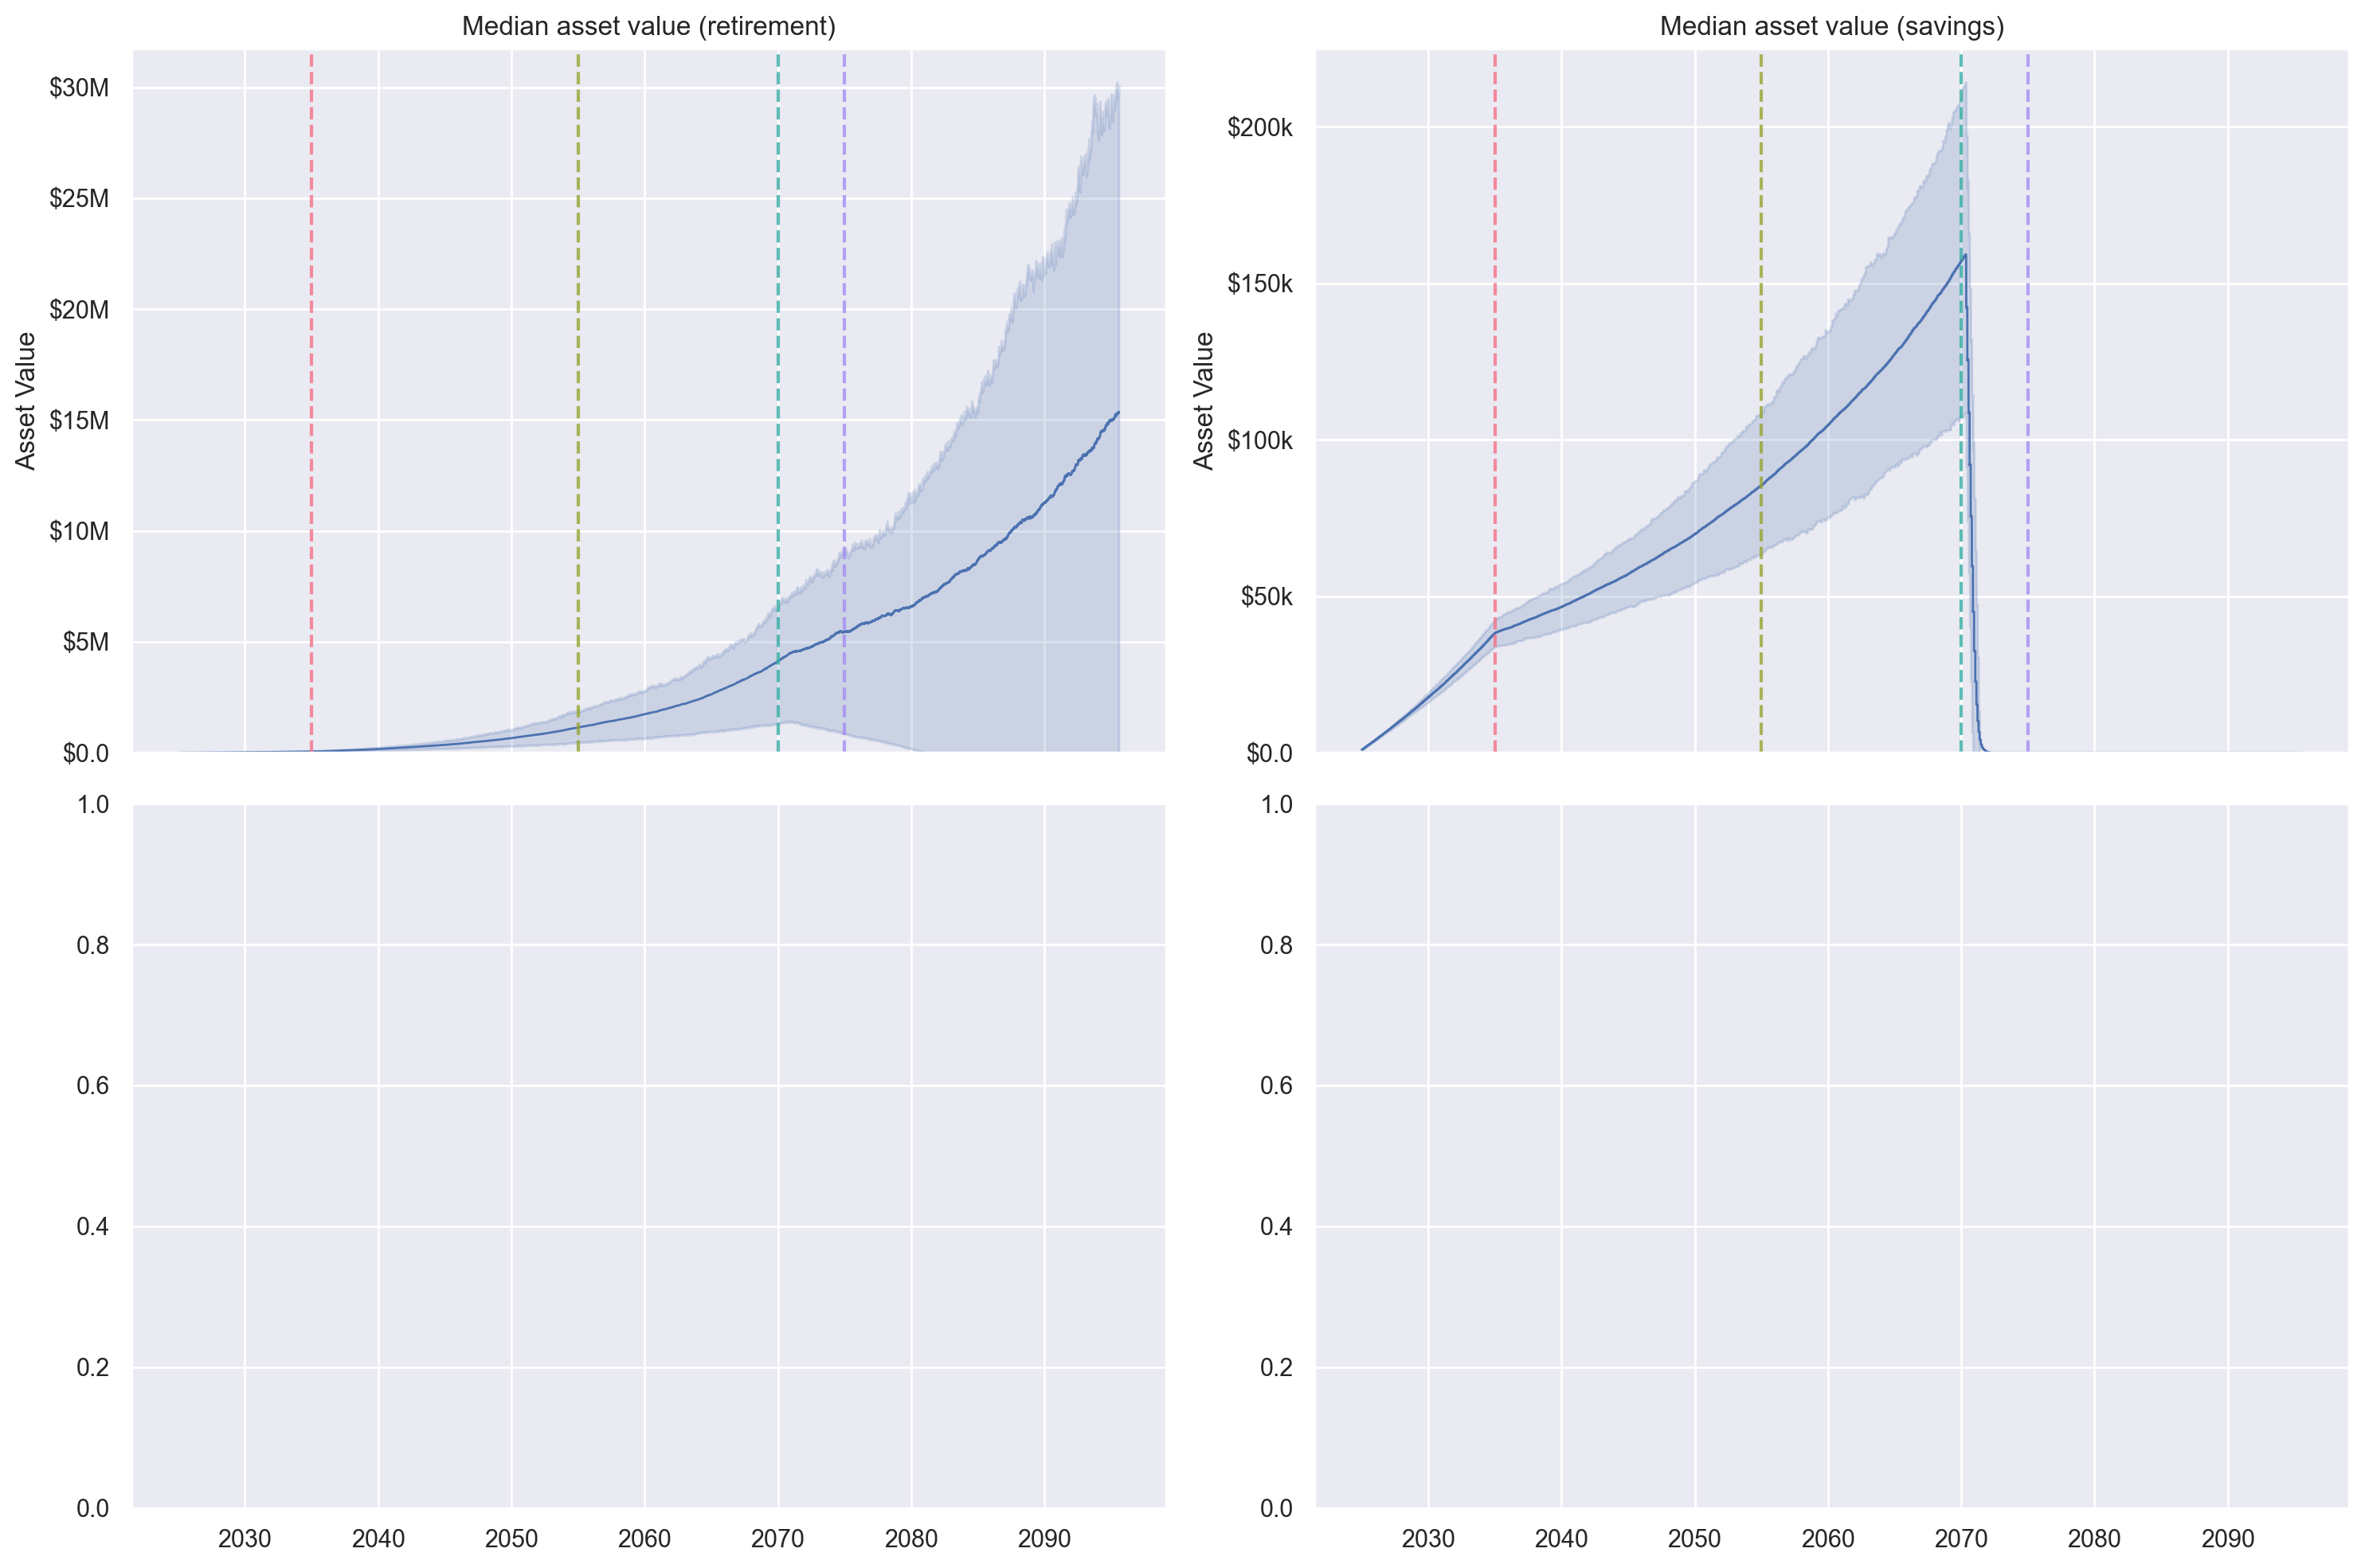

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True)
axes = axes.flatten()

for i, (name, df) in enumerate(simulated_assets_df.items()):
    ax = axes[i]
    # Find the value column that ends with '_value'
    value_cols = [c for c in df.columns if c.endswith("_value")]
    y_col = value_cols[0] if value_cols else df.columns[-2]
    sns.lineplot(
        ax=ax,
        data=df,
        x="trading_date",
        y=y_col,
        legend=False,
        linewidth=1,
        errorbar=("pi", pi),
    )
    if y_axis_scale == "log":
        ax.set_yscale("log")
        ax.set_ylim(bottom=1)
    else:
        ax.set_yscale("linear")
        ax.set_ylim(bottom=0)
    ax.set_title(f"Median asset value ({name})")
    ax.set_ylabel("Asset Value")
    ax.yaxis.set_major_formatter(FuncFormatter(money_formatter))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    add_lifecycle_milestones(ax, show_legend=False)

plt.tight_layout()
plt.show()

## Investment & Draws Over Time

This chart shows the cumulative investments and draws over time,
alongside the median portfolio value. It helps visualize how cash flows impact the overall portfolio.

In [25]:
def create_investment_draw_data(investment_fn, draw_fn, num_years, num_trading_days):
    """Create per-year investment and draw series (not cumulative)."""
    annual_investments = np.zeros(num_years)
    annual_draws = np.zeros(num_years)

    for year in range(num_years):
        annual_investments[year] = investment_fn(year)
        annual_draws[year] = draw_fn(year)

    return annual_investments, annual_draws


# Generate the investment and draw data (per year, not cumulative)
annual_investments, annual_draws = create_investment_draw_data(
    investment_fn, draw_fn, num_years, num_trading_days
)

# Create an annual date series (one point per year) and build the draw_df
annual_dates = [datetime(datetime.now().year + y, 1, 1) for y in range(num_years)]

draw_data = []
for y, date in enumerate(annual_dates):
    draw_data.append(
        {
            "trading_date": date,
            "value": annual_investments[y],
            "variable": "Annual Investments",
        }
    )
    draw_data.append(
        {
            "trading_date": date,
            "value": annual_draws[y],
            "variable": "Annual Draws",
        }
    )

draw_df = pl.DataFrame(draw_data)

# Calculate median portfolio value for the top plot
median_portfolio_df = simulated_totals_df.group_by("trading_date").agg(
    pl.col("portfolio_value").median().alias("median_portfolio_value")
)

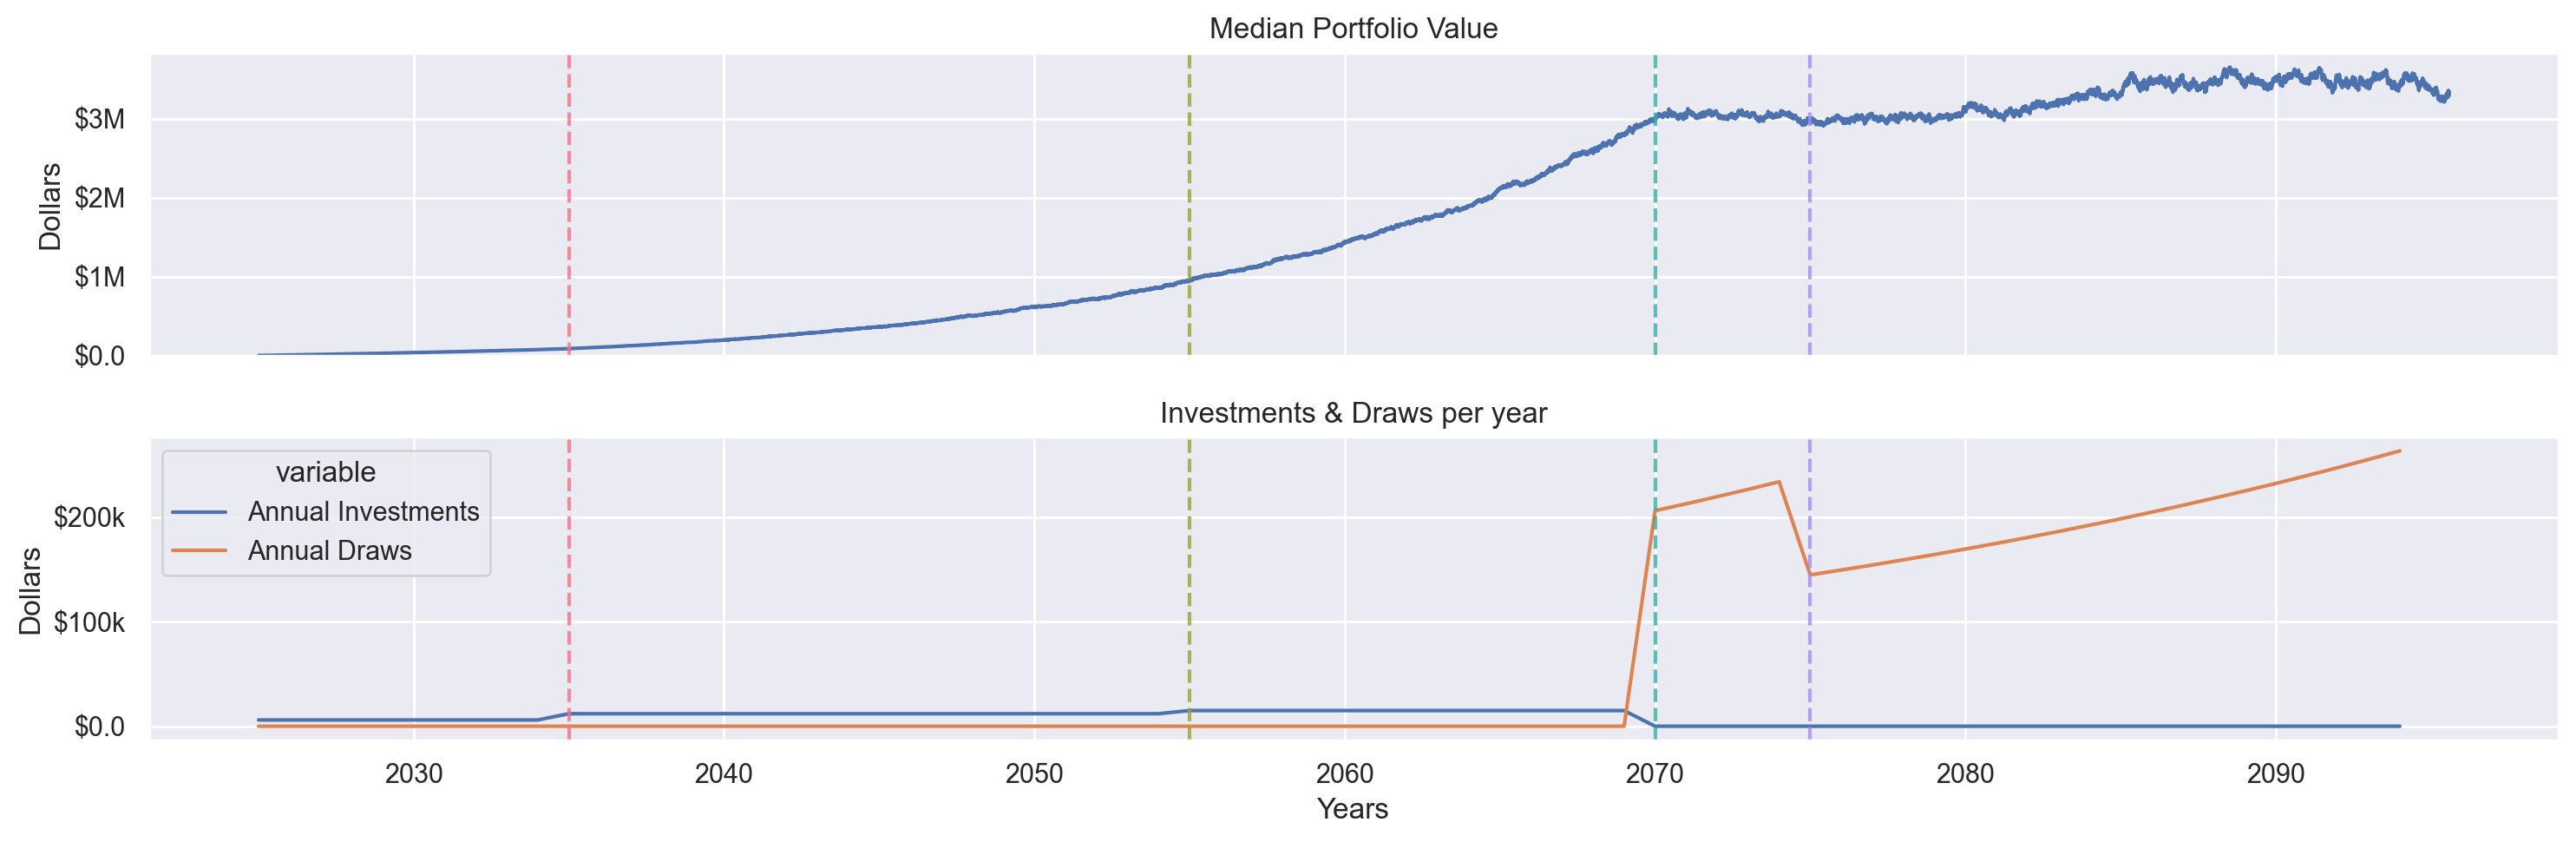

In [26]:
# Convert to Polars DataFrame
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 5))

sns.lineplot(ax=ax2, data=draw_df, x="trading_date", y="value", hue="variable")
add_lifecycle_milestones(ax2, show_legend=False)

# Format the x-axis to show breaks every year, and show money
plt.gca().yaxis.set_major_formatter(FuncFormatter(money_formatter))

# Add labels and title
ax2.set_xlabel("Years")
ax2.set_ylabel("Dollars")
ax2.set_title("Investments & Draws per year")

sns.lineplot(
    ax=ax1,
    data=median_portfolio_df,
    x="trading_date",
    y="median_portfolio_value",
)
add_lifecycle_milestones(ax1, show_legend=False)
if y_axis_scale == "log":
    ax1.set_yscale("log")
    ax1.set_ylim(bottom=1)
else:
    ax1.set_yscale("linear")
    ax1.set_ylim(bottom=0)


ax1.yaxis.set_major_formatter(FuncFormatter(money_formatter))
ax1.set_ylabel("Dollars")
ax1.set_title("Median Portfolio Value")

plt.tight_layout()
plt.show()